# CNN1 과제

## 필요한 라이브러리 import

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import requests
import tarfile

## dataset download

- 디렉토리 생성, 파일 다운로드, 파일 압축해제 흐름으로 진행됨
- 파일이 이미 존재하면 건너뛰도록 함

In [2]:
def download_and_extract_pets_dataset(url, download_path, extract_path):
    # 디렉토리 생성
    os.makedirs(download_path, exist_ok=True)
    os.makedirs(extract_path, exist_ok=True)

    dataset_tar_path = os.path.join(download_path, os.path.basename(url))

    # 파일 다운로드
    if not os.path.exists(dataset_tar_path):
        print(f"Downloading {url}...")
        response = requests.get(url, stream=True)
        with open(dataset_tar_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
        print("Download complete.")
    else:
        print(f"{dataset_tar_path} already exists.")

    # 파일 압축 해제
    if not os.listdir(extract_path):
        print(f"Extracting {dataset_tar_path}...")
        with tarfile.open(dataset_tar_path, "r:gz") as tar:
            tar.extractall(path=extract_path)
        print("Extraction complete.")
    else:
        print(f"{extract_path} already contains extracted data.")

# URLs and paths
image_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
annotation_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
download_dir = "./data/downloads"
image_dir = "/content/data/pets/images/images"
annotation_dir = "/content/data/pets/annotations/annotations"

# Download and extract dataset
download_and_extract_pets_dataset(image_url, download_dir, image_dir)
download_and_extract_pets_dataset(annotation_url, download_dir, annotation_dir)

./data/downloads/images.tar.gz already exists.
/content/data/pets/images/images already contains extracted data.
./data/downloads/annotations.tar.gz already exists.
/content/data/pets/annotations/annotations already contains extracted data.


## custom dataset 구축

- __init__ : 파일 열기 및 이미지 파일 존재여부 확인 등
- __len__ : 데이터셋 크기를 반환
- __getitem__ : 이미지 로딩 및 이미지와 레이블 반환 등

In [3]:
# Dataset Class Implementation
class PetsDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Parse annotation file
        with open(annotation_file, "r") as f:
            for line in f:
                parts = line.strip().split()
                image_name, class_id = parts[0], int(parts[1]) - 1  # Convert class_id to 0-based index
                self.image_paths.append(os.path.join(image_dir, f"{image_name}.jpg"))
                self.labels.append(class_id)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      img_path = self.image_paths[idx]
      label = self.labels[idx]

      # 이미지 경로가 존재하는지 체크
      if not os.path.exists(img_path):
          print(f"Warning: {img_path} not found, skipping this image.")
          return None  # None을 반환하거나 다른 방식으로 처리할 수 있습니다.

      image = Image.open(img_path).convert("RGB")

      if self.transform:
          image = self.transform(image)

      return image, label


## CNN model define

- base model를 ResNet으로 설정하여 작성
- residual block을 사용하여 skip connection 구현
  - 더하여 채널 수가 다를 경우 조정하는 과정을 거침
- fc layer 안에 dropout을 적용하여 일반화 성능을 높이도록 함
- make_layer는 residual blocks를 생성하는 헬퍼 메서드

- 7x7 conv, stride 2로 downsampling

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Residual Block 정의
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_prob=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # self.dropout1 = nn.Dropout2d(p=dropout_prob)  # Dropout 추가

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # self.dropout2 = nn.Dropout2d(p=dropout_prob)  # Dropout 추가

        # Skip connection에서 채널 수 또는 크기가 다를 경우 조정
        self.skip_conv = None
        if stride != 1 or in_channels != out_channels:
            self.skip_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
            self.skip_bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x
        if self.skip_conv:
            identity = self.skip_bn(self.skip_conv(x))

        out = F.relu(self.bn1(self.conv1(x)))
        # out = self.dropout1(out)  # Dropout 적용
        out = self.bn2(self.conv2(out))
        # out = self.dropout2(out)  # Dropout 적용
        out += identity
        return F.relu(out)

# Custom CNN 모델 정의
class CustomCNN(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super(CustomCNN, self).__init__()
        # 첫 번째 Conv 레이어
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)  # 큰 receptive field
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # self.dropout1 = nn.Dropout2d(p=dropout_prob)  # Dropout 추가

        # Residual Blocks
        self.layer1 = self._make_layer(ResidualBlock, 64, 64, num_blocks=2, stride=1, dropout_prob=dropout_prob)
        self.layer2 = self._make_layer(ResidualBlock, 64, 128, num_blocks=2, stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._make_layer(ResidualBlock, 128, 256, num_blocks=2, stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._make_layer(ResidualBlock, 256, 512, num_blocks=2, stride=2, dropout_prob=dropout_prob)

        # Global Average Pooling + Fully Connected Layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        # self.dropout_fc = nn.Dropout(p=dropout_prob)  # Dropout 추가

    def _make_layer(self, block, in_channels, out_channels, num_blocks, stride, dropout_prob):
        layers = []
        layers.append(block(in_channels, out_channels, stride, dropout_prob))  # 첫 번째 Residual Block
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, dropout_prob=dropout_prob))  # 나머지 Residual Block
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        # x = self.dropout1(x)  # Dropout 적용

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten the tensor
        # x = self.dropout_fc(x)  # Fully Connected 전에 Dropout 적용
        x = self.fc(x)
        return x

## hyperparmeter and transform

- 클래수 스는 37로 지정
- 다양한 transform 적용

In [39]:

batch_size = 32
epochs = 100
learning_rate = 0.0001
num_classes = 37  # Number of classes in the Oxford Pets dataset

data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # 더 큰 이미지로 크기 증가
    transforms.RandomHorizontalFlip(),  # 좌우 뒤집기
    transforms.RandomRotation(15),  # 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


## data load and split

- 4:1 비율로 data split

In [40]:
# Load and split the dataset
annotation_file = "/content/data/pets/annotations/annotations/trainval.txt"  # 경로 수정
dataset = PetsDataset(image_dir=image_dir, annotation_file=annotation_file, transform=data_transforms)

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # 10 epoch마다 학습률 0.1배 감소

## Training

- early stopping 구현
- counter가 patience 이상이면 stop하도록 설정

In [41]:
# EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=20, delta=0):
        self.patience = patience  # patience는 성능이 개선되지 않아도 기다리는 에폭 수
        self.delta = delta  # 개선을 인정하는 최소 변화
        self.best_loss = float('inf')  # 가장 낮은 valid loss 값
        self.counter = 0  # patience 초과 횟수
        self.early_stop = False

    def __call__(self, valid_loss):
        if valid_loss < self.best_loss - self.delta:
            self.best_loss = valid_loss
            self.counter = 0  # 성능 개선되었으므로 카운터 초기화
        else:
            self.counter += 1  # 개선되지 않았으므로 카운터 증가
            if self.counter >= self.patience:
                self.early_stop = True  # patience 초과하면 early stopping

# 모델 학습 및 검증 루프 수정
train_losses = []
valid_losses = []

early_stopping = EarlyStopping(patience=5, delta=0.01)  # patience=5, delta=0.01

In [42]:
for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)
    accuracy = 100 * correct / total

    # 기록
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {accuracy:.2f}%")

    # Early stopping 체크
    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

print("Training completed.")


Epoch [1/100]
Train Loss: 3.4864, Valid Loss: 3.4971, Valid Accuracy: 8.70%
Epoch [2/100]
Train Loss: 3.1883, Valid Loss: 3.1972, Valid Accuracy: 11.96%
Epoch [3/100]
Train Loss: 2.9825, Valid Loss: 3.1152, Valid Accuracy: 13.99%
Epoch [4/100]
Train Loss: 2.8067, Valid Loss: 2.9882, Valid Accuracy: 17.93%
Epoch [5/100]
Train Loss: 2.6265, Valid Loss: 3.0311, Valid Accuracy: 14.95%
Epoch [6/100]
Train Loss: 2.4583, Valid Loss: 2.9549, Valid Accuracy: 18.75%
Epoch [7/100]
Train Loss: 2.2842, Valid Loss: 3.2204, Valid Accuracy: 16.44%
Epoch [8/100]
Train Loss: 2.1248, Valid Loss: 2.8802, Valid Accuracy: 23.64%
Epoch [9/100]
Train Loss: 1.9456, Valid Loss: 2.8686, Valid Accuracy: 25.00%
Epoch [10/100]
Train Loss: 1.7592, Valid Loss: 2.7228, Valid Accuracy: 25.14%
Epoch [11/100]
Train Loss: 1.5797, Valid Loss: 2.7807, Valid Accuracy: 24.46%
Epoch [12/100]
Train Loss: 1.3821, Valid Loss: 2.7710, Valid Accuracy: 23.10%
Epoch [13/100]
Train Loss: 1.2742, Valid Loss: 2.8631, Valid Accuracy: 25.

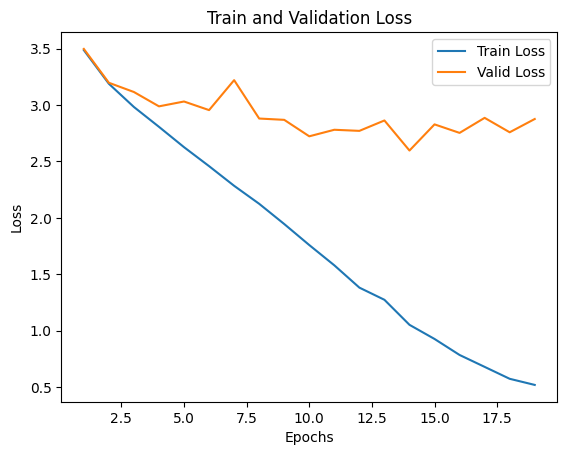

In [43]:
import matplotlib.pyplot as plt

# 학습 및 검증 Loss 시각화
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

## 데이터셋 특징

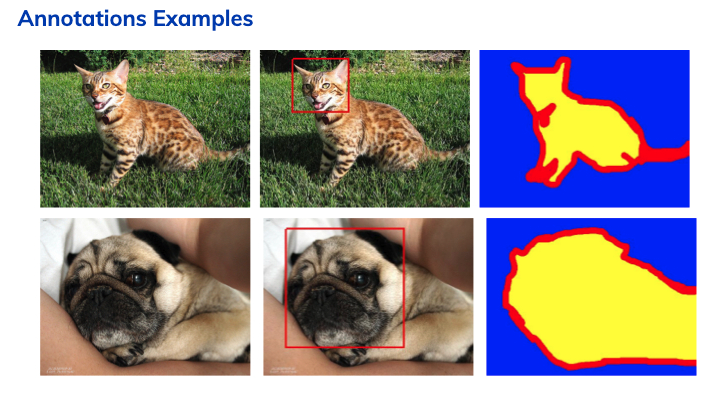

- 반려동물의 이미지와 해당 레이블로 구성
- 총 이미지: 7349장
- class : 37개
  - dog 25, cat 12
- annotation : class labels, segmentation masks

## 분석 및 고찰

- 데이터 수가 적은 편이라 전반적으로 좋은 성능을 내지 못하는 것 같습니다.
- 또한 데이터셋 자체에 클래스 불균형이 존재하여 성능에 영향을 미칠 것으로 예상하였습니다.
- hyperparmeter 조정과정
  - patience: 5 -> 10
  - learning late : 0.001 -> 0.0001
  - dropout: p:0.3 적용 -> 적용하지않음
    - 데이터셋이 작아 충분한 정보를 학습하지 않은 상태에서 일부 뉴런을 비활성화 하게 되면 더 성능이 저하될 거 같다고 생각하였습니다.
    
    (dropout code는 주석처리 해놓았습니다)

- 그래프를 보면 training loss는 줄고있으나 val loss는 그렇지 못한 것을 보아 좋은 학습이 진행되지는 않았습니다